In [2]:
import os
import sys
import GEOparse
import pandas as pd
import numpy as np
import pandas as pd
import gseapy as gp

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from core.stats.tests import test_two_groups

GEOparse.logger.set_verbosity("ERROR")

In [3]:
DATA_DIR = '../../db'
ENRICHR_LIBRARIES = ['WikiPathway_2023_Human', 'KEGG_2021_Human', 'GO_Biological_Process_2023', 'GO_Molecular_Function_2023', 'GO_Cellular_Component_2023', 'Reactome_2022']

In [4]:
gse = GEOparse.get_GEO(geo='GSE116222', destdir="./data/geo_cache")

platform_id = gse.metadata['platform_id'][0]
print(f"Platform ID: {platform_id}")

Platform ID: GPL24676


In [5]:
# read gz file
import gzip

with gzip.open('./data/geo_cache/GSE116222_Expression_matrix.txt.gz', 'rt') as f:
    expr_matrix = pd.read_csv(f, sep='\t', index_col=0)

In [6]:
expression_data = expr_matrix.T

labels = expression_data.index.str.split('-').str[1].to_list()

inflammation_labels = ['UC inflamed' if x.endswith('3') else 'UC non-inflamed' if x.endswith('2') else 'Healthy' for x in labels]
inflammation_labels = pd.Series(inflammation_labels, index=expression_data.index, name='Inflammation')

In [6]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit(expression_data)

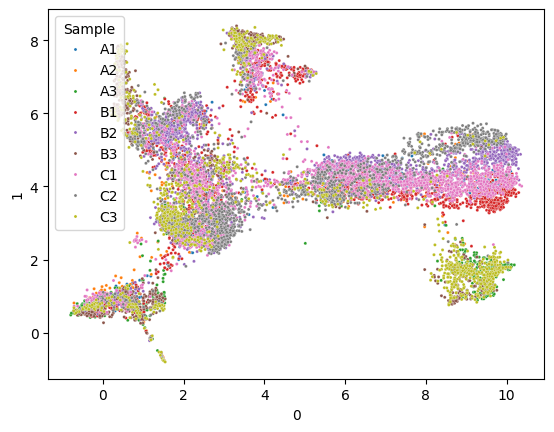

In [7]:
import seaborn as sns

plot_data = pd.concat([pd.DataFrame(embedding), pd.Series(labels).rename('Sample')], axis=1)

sns.scatterplot(data=plot_data, x=0, y=1, hue="Sample", s=5);

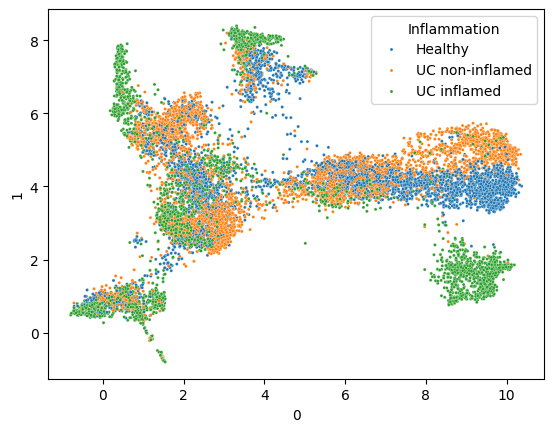

In [8]:
import seaborn as sns

plot_data = pd.concat([pd.DataFrame(embedding), pd.Series(inflammation_labels).rename('Inflammation')], axis=1)

sns.scatterplot(data=plot_data, x=0, y=1, hue="Inflammation", s=5);

1736.477941834452


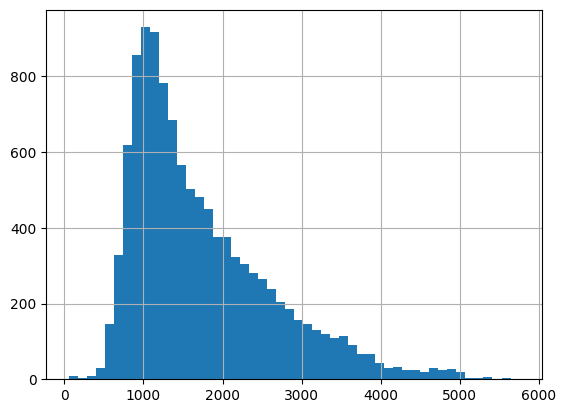

In [54]:
# plot the histogram illustrating the number of non-zero values per sample
expression_data.astype(bool).sum(axis=1).hist(bins=50);

# calculate the mean number of non-zero values per sample
print(expression_data.astype(bool).sum(axis=1).mean());

In [112]:
import numpy as np

from tqdm.notebook import tqdm

from sklearn.ensemble import RandomForestRegressor


class CellLineModel:
    def __init__(self):
        self.models = None
        self.last_prediction_distances = None
        self.previous_states = None

    def fit(self, data):
        self.models = []
        num_features = data.shape[1]

        for i in tqdm(range(num_features), desc="Fitting models"):
            X = np.delete(data, i, axis=1)
            y = data[:, i]
            model = RandomForestRegressor()
            model.fit(X, y)
            self.models.append(model)

        return self


    def predict(self, sample, column_index, value=0, max_iter=100, tol=1e-3):
        modified_sample = sample.copy()
        modified_sample[column_index] = value
        prev_sample = modified_sample.copy()

        distances = []
        self.previous_states = []
        
        for _ in tqdm(range(max_iter), desc="Predicting"):
            new_sample = modified_sample.copy()
            for i in range(len(self.models)):
                if i != column_index:
                    X = np.delete(modified_sample, i)
                    new_sample[i] = self.models[i].predict([X])[0]
            
            dist = np.linalg.norm(new_sample - prev_sample)
            distances.append(dist)

            if dist < tol:
                break

            for ps in self.previous_states:
                if np.allclose(new_sample, ps):
                    print("Loop detected")
                    break

            self.previous_states.append(new_sample)

            prev_sample = new_sample.copy()
            modified_sample = new_sample.copy()

        plot_data = pd.DataFrame(distances, columns=["Distance"])
        plot_data["Iteration"] = plot_data.index
        self.last_prediction_distances = plot_data
        
        return new_sample

In [8]:
from biomart import BiomartServer

server = BiomartServer("http://www.ensembl.org/biomart")
mart = server.datasets['hsapiens_gene_ensembl']

response = mart.search({
    'filters': {
        'biotype': 'protein_coding'
    },
    'attributes': [
        'external_gene_name'
    ]
})

In [9]:
protein_coding_genes = [line.strip() for line in response.iter_lines(decode_unicode=True)]
protein_coding_genes = set(protein_coding_genes)

In [10]:
filtered_df = expression_data[[gene for gene in expression_data.columns if gene in protein_coding_genes]]

In [9]:
# # select only the first 100 samples and 10 genes with the highest variance
# variances = filtered_df.var(axis=0)
# indexes = variances.nlargest(10).index
# data_subset = filtered_df[indexes]

In [70]:
fatty_acid_oxidation_genes = ["ACADL", "ACADM", "ACADS", "ACADVL", "ACAT1", "ACAT2", "CPT1A", "CPT1B", "CPT2", "SLC25A20", "HADHA", "HADHB", "ECHS1", "ETFA", "ETFB", "ETFDH", "ACOX1", "ACOX2", "ACOX3", "HADH", "HSD17B10", "MTP", "MCAT", "SCP2", "DECR1", "DECR2", "PECR", "EHHADH"]

glycolysis_genes = ["HK1", "HK2", "HK3", "GCK", "GPI", "PFKL", "PFKM", "PFKP", "ALDOA", "ALDOB", "ALDOC", "TPI1", "GAPDH", "PGK1", "PGK2", "PGAM1", "PGAM2", "ENO1", "ENO2", "ENO3", "PKM", "PKLR"]

oxygen_expression_regulation_genes = ["HIF1A", "HIF2A", "HIF3A", "EGLN1", "EGLN2", "EGLN3", "VHL", "ARNT", "EPAS1", "PHD1", "PHD2", "PHD3", "HIF1AN", "CITED2", "PHD4"]

# filter the data to include only the genes of interest
data_subset = filtered_df[[gene for gene in filtered_df.columns if gene in fatty_acid_oxidation_genes + glycolysis_genes + oxygen_expression_regulation_genes]]

In [71]:
# split the data into training and testing sets
train_data_df = data_subset.sample(frac=0.8)
test_data_df = data_subset.drop(train_data_df.index)

train_data = train_data_df.to_numpy()
test_data = test_data_df.to_numpy()

In [116]:
model = CellLineModel()

mode = model.fit(train_data)

Fitting models:   0%|          | 0/59 [00:00<?, ?it/s]

In [119]:
# check how much memory the models take
import sys

print(np.round(sys.getsizeof(model) / 1024 / 1024, 4), "MB")

0.0001 MB


In [185]:
sample = train_data[2]

# ko the PHD1 gene
column_index = test_data_df.columns.get_loc("EGLN2")
new_value = 0
# new_value = sample[column_index]

stable_state = model.predict(sample, column_index, value=new_value, max_iter=100, tol=0.1)

np.linalg.norm(stable_state - sample)

Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

4.936328276942173

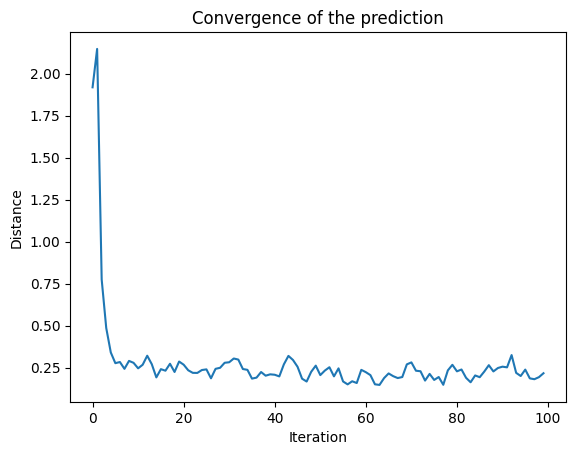

In [186]:
import matplotlib.pyplot as plt

dists = model.last_prediction_distances

plt.plot(dists["Iteration"], dists["Distance"])
plt.xlabel("Iteration")
plt.ylabel("Distance")
plt.title("Convergence of the prediction");

In [ ]:
# Model validation on train and test data with progress bar
def validate_model(model, data, no_samples=10, no_genes=10):
    distances = []
    
    sampled_genes = np.random.choice(data.shape[1], no_genes, replace=False)
    sampled_data = data[np.random.choice(data.shape[0], no_samples, replace=False)]

    for sample in tqdm(sampled_data, desc="Validating"):
        for column_index in sampled_genes:
            new_value = sample[column_index]
            stable_state = model.predict(sample, column_index, value=new_value, max_iter=100)
            dist = np.linalg.norm(stable_state - sample)
            distances.append(dist)

    return distances

train_distances = validate_model(model, train_data)
test_distances = validate_model(model, test_data)

# compare the results on a single violin plot
import seaborn as sns

plot_data = pd.DataFrame({
    "Distance": train_distances + test_distances,
    "Dataset": ["Train"] * len(train_distances) + ["Test"] * len(test_distances)
})

sns.violinplot(data=plot_data, x="Dataset", y="Distance");

In [190]:
# save train_distances to a file
# with open("train_distances.npy", "wb") as f:
#     np.save(f, train_distances)

In [191]:
# read train_distances from file
# with open("train_distances.npy", "rb") as f:
#     train_distances_from_file = np.load(f)

In [152]:
import umap

reducer = umap.UMAP()
reducer = reducer.fit(train_data)

In [164]:
train_embedding = reducer.transform(train_data)
test_embedding = reducer.transform(test_data)

In [187]:
original_sample_embedding = reducer.transform(sample.reshape(1, -1))
original_sample_altered = sample.copy()
original_sample_altered[column_index] = new_value
original_sample_altered_embedding = reducer.transform(original_sample_altered.reshape(1, -1))
stable_sample_embedding = reducer.transform(stable_state.reshape(1, -1))

/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_1572/3514996801.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('RdYlGn')(np.linspace(0, 1, num_samples))


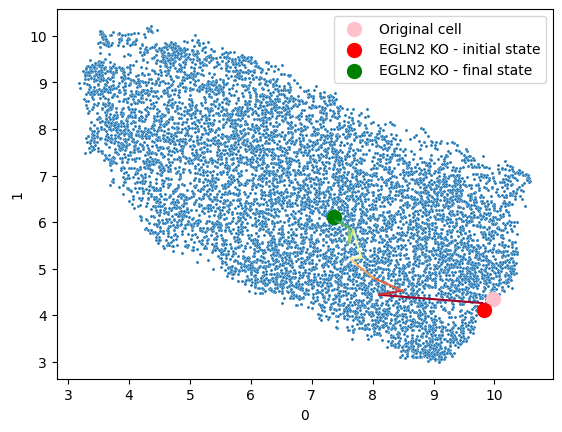

In [188]:
# Using the previous states in the model, plot the trajectory of the prediction for the altered sample in the UMAP space
previous_states = model.previous_states

selected = [0, 1]
while True:
    next_num = selected[-1] + selected[-2]
    if next_num >= 100:
        break
    selected.append(next_num)

selected_previous_states = [model.previous_states[idx] for idx in selected]
previous_states_embedding = reducer.transform(selected_previous_states)

import seaborn as sns

plot_data = pd.concat([pd.DataFrame(train_embedding)], join='inner', axis=1)

sns.scatterplot(data=plot_data, x=0, y=1, s=5);
# plt.plot(previous_states_embedding[:, 0], previous_states_embedding[:, 1], color='green', label="Trajectory")

import matplotlib.cm as cm

# Normalize the position in the array to the range [0, 1]
num_samples = previous_states_embedding.shape[0]
colors = cm.get_cmap('RdYlGn')(np.linspace(0, 1, num_samples))

# Plot each segment with the corresponding color
for i in range(num_samples - 1):
    plt.plot(previous_states_embedding[i:i+2, 0], previous_states_embedding[i:i+2, 1], color=colors[i])

plt.scatter(original_sample_embedding[:, 0], original_sample_embedding[:, 1], color='pink', s=100, label="Original cell")
plt.scatter(original_sample_altered_embedding[:, 0], original_sample_altered_embedding[:, 1], color='red', s=100, label="EGLN2 KO - initial state")
plt.scatter(stable_sample_embedding[:, 0], stable_sample_embedding[:, 1], color='green', s=100, label="EGLN2 KO - final state")
plt.legend();

## Cell type annotation

In [11]:
import scanpy as sc
import celltypist

adata = sc.AnnData(filtered_df)

In [12]:
model = celltypist.models.download_models(model = 'Human_Colorectal_Cancer.pkl')
predictions = celltypist.annotate(adata, model='Human_Colorectal_Cancer.pkl')
adata.obs['cell_type'] = predictions.predicted_labels

cell_type_labels = adata.obs['cell_type']

📂 Storing models in /Users/maciejpiernik/.celltypist/data/models
💾 Total models to download: 1
⏩ Skipping [1/1]: Human_Colorectal_Cancer.pkl (file exists)
⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 11175 cells and 17904 genes
🔗 Matching reference genes in the model
🧬 3838 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [13]:
data_with_inflammation = pd.concat([filtered_df, inflammation_labels], join='inner', axis=1)
data_with_inflammation = data_with_inflammation[data_with_inflammation['Inflammation'].isin(['Healthy', 'UC inflamed'])]

In [47]:
test_results = test_two_groups(data_with_inflammation, 'Inflammation', alpha=0.05/data_with_inflammation.shape[1])

Test results for Inflammation:
Group counts: 4249 | 2848
- FABP1: [Mann-Whitney U test] p-value = 0.0; mean difference = -1.8449
- CKB: [Mann-Whitney U test] p-value = 0.0; mean difference = -1.579
- MT1G: [Mann-Whitney U test] p-value = 0.0; mean difference = -1.3091
- LGALS4: [Mann-Whitney U test] p-value = 0.0; mean difference = -1.2323
- SLC26A2: [Mann-Whitney U test] p-value = 0.0; mean difference = -1.1979
- MT1E: [Mann-Whitney U test] p-value = 0.0; mean difference = -1.1179
- CHCHD10: [Mann-Whitney U test] p-value = 0.0; mean difference = -0.8683
- HMGCS2: [Mann-Whitney U test] p-value = 0.0; mean difference = -0.8421
- HLA-DQB1: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.4201
- LYZ: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.4817
- SAA1: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.4947
- HLA-DPA1: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.5268
- DMBT1: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.5863
- DUOXA2

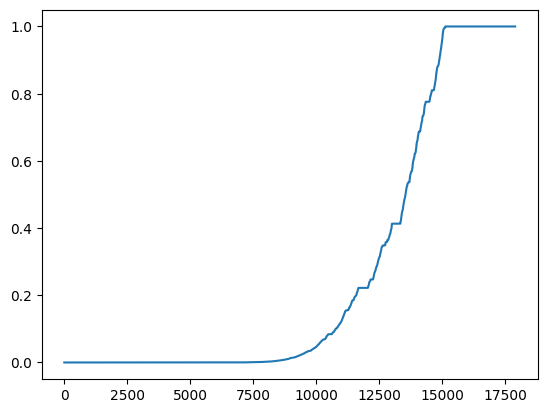

In [51]:
import matplotlib.pyplot as plt

plt.plot([p for f, (p, d, t) in test_results]);

In [52]:
genes = [f for f, (p, d, t) in test_results if p < 0.05/data_with_inflammation.shape[1]]

In [71]:
# libraries = gp.get_library_name(organism='Human')
# print(libraries)

gene_list = genes[:500]

enrichr_results = gp.enrichr(gene_list=gene_list, gene_sets=ENRICHR_LIBRARIES[0], organism='Human', outdir='../../results/enrichr_sc', cutoff=0.05)

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 31 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'H', 'P', 'W', 'a', 'd', 'e', 'h', 'hyphen', 'i', 'j', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'parenleft', 'parenright', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'w', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 21, 22, 36, 43, 51, 58, 66, 68, 71, 72, 75, 76, 77, 78, 79, 80, 81, 86, 87, 88, 89, 90, 92]
Closed glyph list over 'GSUB': 31 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'H', 'P', 'W', 'a', 'd', 'e', 'h', 'hyphen', 'i', 'j', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'parenleft', 'parenright', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'w', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 21, 22, 36, 43, 51, 58, 66, 68, 71, 72, 75, 76, 77, 78, 79, 80, 81, 86, 87, 88, 89, 90, 92]
Closing

In [72]:
enrichr_results.res2d[enrichr_results.res2d['Adjusted P-value'] < 0.05].sort_values('Combined Score', ascending=False).head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
2,WikiPathway_2023_Human,Macrophage Markers WP4146,2/9,0.000041,0.000704,0,0,285.300000,2879.406823,CD74;LYZ
13,WikiPathway_2023_Human,Disorders In Ketone Body Synthesis WP5175,1/5,0.005488,0.017494,0,0,237.785714,1237.703279,HMGCS2
14,WikiPathway_2023_Human,Creatine Pathway WP5190,1/5,0.005488,0.017494,0,0,237.785714,1237.703279,CKB
15,WikiPathway_2023_Human,Ketone Bodies Synthesis And Degradation WP311,1/5,0.005488,0.017494,0,0,237.785714,1237.703279,HMGCS2
3,WikiPathway_2023_Human,Pathogenesis Of SARS CoV 2 Mediated By Nsp9 Ns...,2/21,0.000240,0.003054,0,0,105.047368,875.774985,HLA-DRA;HLA-DRB1
0,WikiPathway_2023_Human,Allograft Rejection WP2328,4/90,0.000003,0.000134,0,0,51.400517,660.308594,HLA-DRA;HLA-DRB1;HLA-DQB1;HLA-DPA1
4,WikiPathway_2023_Human,Cell Interactions Of The Pancreatic Cancer Mic...,2/26,0.000369,0.003140,0,0,83.141667,657.115460,HLA-DRA;HLA-DRB1
5,WikiPathway_2023_Human,Cytokines And Inflammatory Response WP530,2/26,0.000369,0.003140,0,0,83.141667,657.115460,HLA-DRA;HLA-DRB1
6,WikiPathway_2023_Human,Zinc Homeostasis WP3529,2/36,0.000711,0.005183,0,0,58.658824,425.178229,MT1G;MT1E
1,WikiPathway_2023_Human,Ebola Virus Infection In Host WP4217,4/129,0.000011,0.000282,0,0,35.294222,402.842373,HLA-DRA;HLA-DRB1;HLA-DQB1;HLA-DPA1


In [87]:
ranking = pd.DataFrame([(g, p) for g, (p, d, t) in test_results if p < 0.05/data_with_inflammation.shape[1]], columns=['Gene', 'P-value']).set_index('Gene')

ranking.to_csv('../../results/sc_ranking.csv')

In [84]:
pre_res = gp.prerank(rnk=(1 - ranking),
    gene_sets='WikiPathway_2023_Human',
    threads=1,
    min_size=5,
    max_size=1000,
    permutation_num=1000, # reduce number to speed up testing
    outdir=None, # don't write to disk
    seed=6,
    verbose=True, # see what's going on behind the scenes
)

2024-06-02 18:18:08,767 [WARNING] Duplicated values found in preranked stats: 44.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-06-02 18:18:08,777 [INFO] Parsing data files for GSEA.............................
2024-06-02 18:18:08,786 [INFO] Enrichr library gene sets already downloaded in: /Users/maciejpiernik/.cache/gseapy, use local file
2024-06-02 18:18:08,864 [INFO] 0183 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-06-02 18:18:08,874 [INFO] 0618 gene_sets used for further statistical testing.....
2024-06-02 18:18:08,878 [INFO] Start to run GSEA...Might take a while..................


In [85]:
pre_res.res2d.head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Electron Transport Chain OXPHOS System In Mito...,0.471851,3.686516,0.0,0.0,0.0,37/44,37.28%,COX17;NDUFA11;SURF1;NDUFB4;NDUFB2;NDUFC1;NDUFA...
1,prerank,Nuclear Receptors Meta Pathway WP2882,0.219127,2.962156,0.0,0.0,0.0,75/133,35.00%,FABP1;NR1H3;GADD45B;SLC39A1;SLC39A8;SLC39A6;GG...
2,prerank,Nonalcoholic Fatty Liver Disease WP4396,0.267571,2.913122,0.0,0.0,0.0,48/87,28.83%,NR1H3;RELA;EIF2S1;NDUFA11;NR1H4;IL1B;NDUFB4;ND...
3,prerank,Mitochondrial Complex IV Assembly WP4922,0.515274,2.766655,0.0,0.000892,0.003,15/19,27.60%,COX17;SURF1;COA3;HIGD1A;COX4I1;COX7A2;COX5B;CO...
4,prerank,Allograft Rejection WP2328,0.33854,2.707083,0.0,0.001665,0.007,29/47,28.13%,IL1B;TGFB1;HLA-DOA;VIM;CD28;CXCR5;IL2RA;ABCB1;...
5,prerank,Complement System WP2806,0.401238,2.649478,0.0,0.002181,0.011,26/29,49.74%,FKBP2;RPS19;ADM;FCER2;ICAM1;CFI;SELPLG;CFD;SFT...
6,prerank,Oxidative Phosphorylation WP623,0.480709,2.519993,0.0,0.006287,0.034,18/20,42.10%,NDUFA11;NDUFB4;NDUFB2;NDUFC1;NDUFA6;NDUFV1;NDU...
7,prerank,Adipogenesis WP236,0.262117,2.464797,0.0,0.008624,0.054,38/60,37.40%,NR1H3;IL6ST;RORA;GADD45B;DVL1;STAT5B;E2F4;CELF...
8,prerank,Platelet Mediated Interactions With Vascular A...,0.742549,2.351284,0.0,0.017314,0.121,7/7,25.84%,IL1B;ICAM1;TGFB1;SELPLG;VCAM1;PF4;CD40
9,prerank,Synaptic Signaling Pathways Associated With Au...,-0.427662,-2.282101,0.002,0.180869,0.176,17/19,46.87%,MTOR;NTRK2;NF1;PIK3CA;TSC1;PIK3CD;GSK3B;AKT3;P...


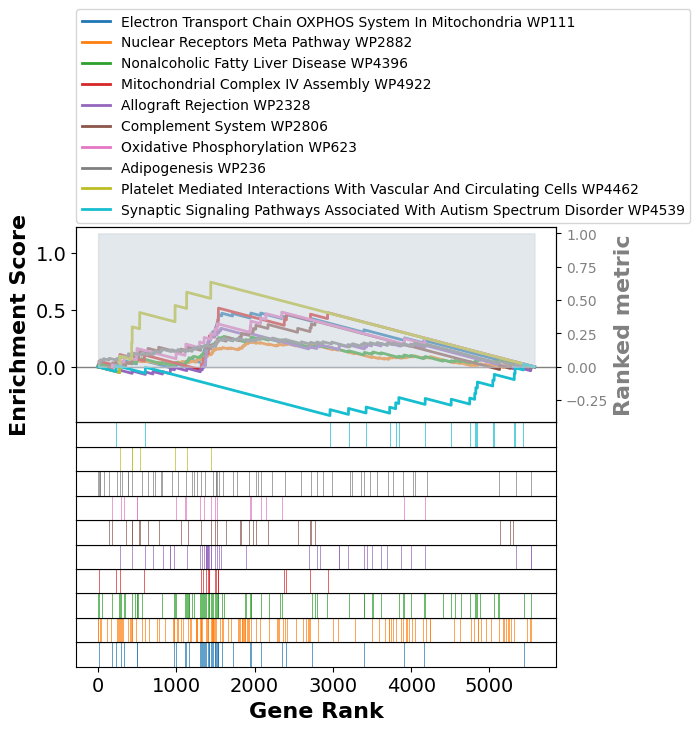

In [86]:
axs = pre_res.plot(pre_res.res2d.Term.head(10), show_ranking=True)

In [14]:
#TODO: now the same analysis but only in epithelial cells


selected_epithelial_cells = ['Mature Enterocytes type 2', 'Stem-like/TA', 'Mature Enterocytes type 1', 'Intermediate', 'Goblet cells']

data_for_test = pd.concat([data_with_inflammation, cell_type_labels], join='inner', axis=1)
data_for_test = data_for_test[data_for_test['cell_type'].isin(selected_epithelial_cells)]
data_for_test = data_for_test.drop('cell_type', axis=1)

In [15]:
test_results_epithelial_cells = test_two_groups(data_for_test, 'Inflammation', alpha=0.05/data_for_test.shape[1])

Test results for Inflammation:
Group counts: 3504 | 726
- DUOXA2: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7631
- DUOX2: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.9842
- HLA-DRA: [Mann-Whitney U test] p-value = 0.0; mean difference = 1.0185
- CD74: [Mann-Whitney U test] p-value = 0.0; mean difference = 1.5121
- LCN2: [Mann-Whitney U test] p-value = 0.0; mean difference = 2.42
- PLA2G2A: [Mann-Whitney U test] p-value = 0.0; mean difference = 2.2065
- OLFM4: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.8578
- DMBT1: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7392
- PI3: [Mann-Whitney U test] p-value = 0.0; mean difference = 1.4556
- SAA1: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.444
- HLA-DRB1: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.7428
- REG1A: [Mann-Whitney U test] p-value = 0.0; mean difference = 0.3697
- S100P: [Mann-Whitney U test] p-value = 0.0; mean difference = 1.3897
- LYZ: [Mann-Whitney 

In [16]:
genes_epithelial_cells = [f for f, (p, d, t) in test_results_epithelial_cells if p < 0.05/data_for_test.shape[1]]

ranking_epithelial = pd.DataFrame([(g, p) for g, (p, d, t) in test_results_epithelial_cells if p < 0.05/data_for_test.shape[1]], columns=['Gene', 'P-value']).set_index('Gene')

In [17]:
# libraries = gp.get_library_name(organism='Human')
# print(libraries)

gene_list = genes_epithelial_cells

enrichr_results = gp.enrichr(gene_list=gene_list, gene_sets=ENRICHR_LIBRARIES[0], organism='Human', outdir='../../results/enrichr_sc', cutoff=0.05)

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 31 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'H', 'P', 'W', 'a', 'd', 'e', 'h', 'hyphen', 'i', 'j', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'parenleft', 'parenright', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'w', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 21, 22, 36, 43, 51, 58, 66, 68, 71, 72, 75, 76, 77, 78, 79, 80, 81, 86, 87, 88, 89, 90, 92]
Closed glyph list over 'GSUB': 31 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'H', 'P', 'W', 'a', 'd', 'e', 'h', 'hyphen', 'i', 'j', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'parenleft', 'parenright', 's', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'w', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 21, 22, 36, 43, 51, 58, 66, 68, 71, 72, 75, 76, 77, 78, 79, 80, 81, 86, 87, 88, 89, 90, 92]
Closing

In [21]:
enrichr_results.res2d[enrichr_results.res2d['Adjusted P-value'] < 0.05].head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathway_2023_Human,Cytoplasmic Ribosomal Proteins WP477,79/88,2.123249e-66,1.571204e-63,0,0,75.414472,11404.000677,RPL5;RPL30;RPL3;RPL32;RPL31;RPLP1;RPL34;RPLP0;...
1,WikiPathway_2023_Human,Nonalcoholic Fatty Liver Disease WP4396,64/154,4.548786e-23,1.683051e-20,0,0,6.038153,310.630343,NDUFA13;GSK3A;COX7B;CXCL8;NDUFA11;IRS1;COX4I1;...
2,WikiPathway_2023_Human,VEGFA VEGFR2 Signaling WP3888,108/430,1.607414e-17,3.964955e-15,0,0,2.871167,111.026088,RPL5;RPL10A;RPL7;ICAM1;ACTG1;RPS6KA5;RPL18A;CC...
3,WikiPathway_2023_Human,IL 24 Signaling Pathway WP5413,69/232,1.484629e-15,2.746564e-13,0,0,3.588216,122.514650,RB1;CDKN1A;CD40;NDUFA13;CXCL8;CD82;ITGB4;TRADD...
4,WikiPathway_2023_Human,Electron Transport Chain OXPHOS System In Mito...,40/105,1.922765e-13,2.845692e-11,0,0,5.173304,151.473531,NDUFB9;NDUFA13;COX7B;NDUFB7;NDUFA11;UQCRB;NDUF...
5,WikiPathway_2023_Human,Gastrin Signaling Pathway WP4659,40/115,5.823237e-12,7.181993e-10,0,0,4.481009,115.919952,ITGB1;CDKN1A;CXCL8;IRS1;SRC;PXN;FOXO3;ELAVL1;R...
6,WikiPathway_2023_Human,Type II Interferon Signaling WP619,21/37,1.014918e-11,1.072913e-09,0,0,10.965587,277.578795,CIITA;NOS2;IFNGR1;STAT1;IFNGR2;STAT2;REG1A;IFI...
7,WikiPathway_2023_Human,Immune Response To Tuberculosis WP4197,16/22,1.239625e-11,1.146653e-09,0,0,22.239676,558.518921,IFNAR2;IFITM1;STAT1;IFNGR1;STAT2;IFNGR2;MX1;TA...
8,WikiPathway_2023_Human,Nuclear Receptors Meta Pathway WP2882,75/314,1.993254e-11,1.514243e-09,0,0,2.656200,65.445221,SERPINA1;HSP90AB1;SLC2A1;TNFAIP3;IRS2;DBI;SLC7...
9,WikiPathway_2023_Human,Ebola Virus Infection In Host WP4217,42/129,2.046274e-11,1.514243e-09,0,0,4.057183,99.857072,ITGB1;ICAM2;CLTB;EGFR;RELA;ACTG1;SOCS3;HLA-DMA...


In [22]:
enrichr_results.res2d[enrichr_results.res2d.Term == 'Mitochondrial Fatty Acid Oxidation Disorders WP5123']

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
271,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,5/19,0.046413,0.126118,0,0,2.96196,9.093721,ECI1;ACSL4;ACSL3;ACADS;ACSF2


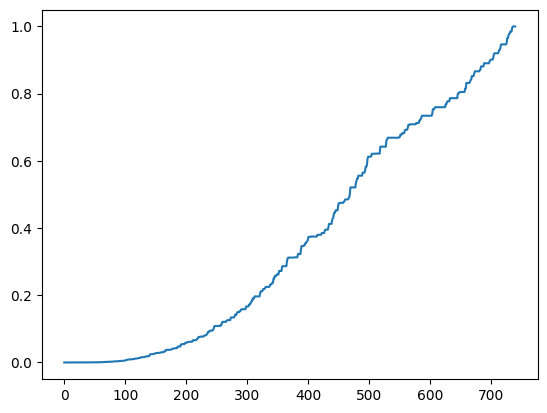

In [30]:
import matplotlib.pyplot as plt

# plot on a log y scale
plt.plot(enrichr_results.res2d['Adjusted P-value']);

In [66]:
all_results = pd.DataFrame([(g, p, m) for (g, (p, m, t)) in test_results_epithelial_cells])
all_results.columns = ['gene', 'p', 'diff']
all_results = all_results.reset_index()
all_results.columns = ['rank', 'gene', 'p', 'diff']

# significant_results = all_results[all_results['p'] < 0.05/data_for_test.shape[1]]

In [53]:
pathways = {}
for library in ENRICHR_LIBRARIES:
    pathway = gp.get_library(name=library, organism='Human')
    pathways.update(pathway)

Library is already downloaded in: /Users/maciejpiernik/.cache/gseapy/Enrichr.WikiPathway_2023_Human.gmt, use local file
0001 gene_sets have been filtered out when max_size=2000 and min_size=0
0002 gene_sets have been filtered out when max_size=2000 and min_size=0
0002 gene_sets have been filtered out when max_size=2000 and min_size=0


In [67]:
no_genes = data_for_test.shape[1]

pathway_ranks = pd.DataFrame()
for pathway in pathways:
    pathway_genes = pathways[pathway]
    pathway_genes_rank = all_results[all_results['gene'].isin(pathway_genes)]['rank'].tolist()
    if len(pathway_genes_rank) == 0:
        continue

    pathway_rank_weighted_sum = np.sum([(no_genes - r) / no_genes for r in pathway_genes_rank])
    pathway_no_genes = len(pathway_genes)
    pathway_score = pathway_rank_weighted_sum / pathway_no_genes

    pathway_ranks = pd.concat([pathway_ranks, pd.DataFrame({'pathway': pathway, 'genes': str(pathway_genes), 'ranks': str(pathway_genes_rank), 'mean_rank': np.mean(pathway_genes_rank), 'no_genes': len(pathway_genes_rank), 'weighted_sum': pathway_rank_weighted_sum, 'total_genes': pathway_no_genes, 'score': pathway_score}, index=[0])])

In [68]:
pathway_ranks.sort_values('score', ascending=False).head(20)

,pathway,genes,ranks,mean_rank,no_genes,weighted_sum,total_genes,score
0,Ubiquitin Ligase Inhibitor Activity (GO:1990948),"['RPL5', 'RPS15', 'RPL11', 'RPS7', 'RPL37', 'R...","[102, 122, 128, 449, 521, 983, 1228]",504.714286,7,6.802681,7,0.971812
0,Interleukin-27-Mediated Signaling Pathway (GO:...,"['MX1', 'OAS2', 'STAT1', 'OAS1', 'OASL']","[243, 691, 693, 732, 942]",660.200000,5,4.815638,5,0.963128
0,Cytoplasmic Ribosomal Proteins WP477,"['RPL22', 'RPS8', 'RPL21', 'RPS9', 'RPL24', 'R...","[62, 67, 73, 79, 87, 92, 94, 95, 98, 99, 100, ...",890.885057,87,82.671209,88,0.939446
0,Ubiquitin-Protein Transferase Inhibitor Activi...,"['RPL5', 'RPS15', 'GLMN', 'RPL11', 'RPS7', 'RP...","[102, 122, 128, 449, 521, 983, 1228, 7009]",1317.750000,8,7.411226,8,0.926403
0,Hydrogen Peroxide Biosynthetic Process (GO:005...,"['DUOX1', 'DUOX2', 'MAOB', 'CYBA', 'SOD1']","[1, 867, 892, 1944, 3604]",1461.600000,5,4.591846,5,0.918369
0,Peptide Chain Elongation R-HSA-156902,"['RPL22', 'RPS8', 'RPL21', 'RPS9', 'RPS6', 'RP...","[62, 67, 73, 79, 87, 92, 94, 95, 98, 99, 101, ...",1460.764706,85,78.065345,86,0.907737
0,Endosomal/Vacuolar Pathway R-HSA-1236977,"['CTSL', 'HLA-C', 'HLA-A', 'HLA-B', 'LNPEP', '...","[16, 26, 30, 42, 44, 113, 171, 348, 3983, 6638...",1798.636364,11,9.895001,11,0.899546
0,Regulation Of Protein Deubiquitination (GO:009...,"['ZC3H12A', 'TNIP1', 'TRIM21', 'TANK', 'OTUD4']","[387, 474, 1683, 2394, 4087]",1805.000000,5,4.495951,5,0.899190
0,Eukaryotic Translation Elongation R-HSA-156842,"['RPL22', 'RPS8', 'RPL21', 'RPS9', 'RPS6', 'RP...","[62, 67, 73, 79, 87, 92, 94, 95, 98, 99, 101, ...",1643.426966,89,80.831053,90,0.898123
0,Activation Of Caspases Thru Apoptosome-Mediate...,"['CASP9', 'APAF1', 'CASP7', 'XIAP', 'CASP3', '...","[459, 494, 903, 1821, 2834, 4470]",1830.166667,6,5.386708,6,0.897785


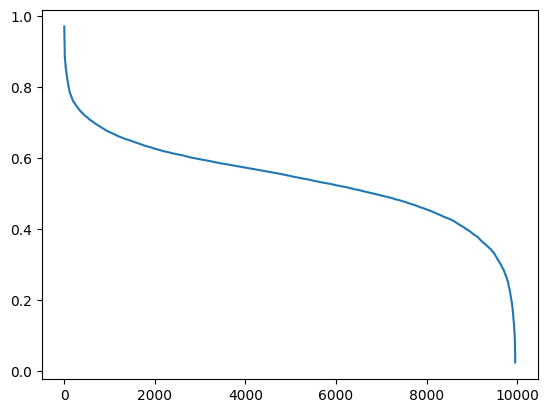

In [74]:
plt.plot(pathway_ranks.sort_values('score', ascending=False)['score'].tolist());